In [20]:
import re
from io import StringIO
from Bio import Phylo

## 1. Define the problem:

> The problem is to prune phylogenetic tree in newick format. Basically it requires to cut off non-sample branch and shorten the paths from root to all sample branches for whatever reason. The phylogenetic tree sets are not generalized, it has two patterns:
- (1) Each tree only has 3 sample branches;
- (2) The 3 sample branches stop at given time (1, 3, 5 time units from begining or 0, 2, 4 time units to now)
- (3) Non-sample branches die (stop) at any time
> <br><br>This process is shown as following:

### 1.1 input: 
- in string format:
    
> ( (sample:0.041890,  ( (:2.836810,  ( (:1.163475,  (sample:0.906388, :0.906388):0.257087):1.268761, sample:0.432236):0.404574):0.731751, :0.256508):0.473330):0.844588, :1.158814):0.113521;

- in graph:

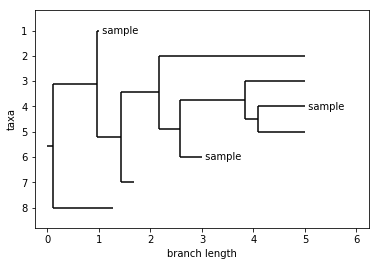

In [50]:
input = "( (sample:0.041890, ( (:2.836810, ( (:1.163475, (sample:0.906388, :0.906388):0.257087):1.268761, sample:0.432236):0.404574):0.731751, :0.256508):0.473330):0.844588, :1.158814):0.113521;"
input_demo = Phylo.read(StringIO(input), "newick")
Phylo.draw(input_demo)

### 1.2 output: 
- in string format:
    
>(1:0.041890,(2:0.432236,3:2.432236):1.609654):0.958110;

- in graph:

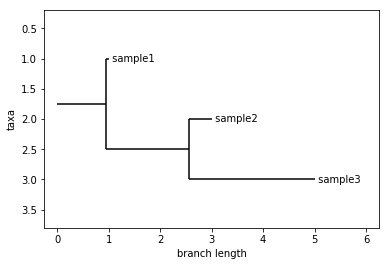

In [53]:
output = "(sample1:0.041890,(sample2:0.432236,sample3:2.432236):1.609654):0.958110;"
output_demo = Phylo.read(StringIO(output), "newick")
Phylo.draw(output_demo)

## 2. Use Patterns to solve the problem:

> What I first thought is to identify patterns and apply specific operation for each one. When you look at input and output, and compare strings and graph, you might notice that there are two universal conditions:
- (1) The useless braches (non-sample branch) and useful braches (sample branch) almost show up in pairwise.The target is to cut off the useless one and add age of root to the sample branch. (Pattern 1&2)
- (2) Two useless braches are linked togther, the whole branches needs to be removed. (Pattern 3)

> String operation with regular expression can solve the problem, simply by matching pattern and substitute / delete sub-string. 


In [43]:
allPattern =  (r"\(:[0-9].[0-9]{3,6},sample:[0-9].[0-9]{3,6}\):[0-9].[0-9]{3,6}|" 
               r"\(sample:[0-9].[0-9]{3,6},:[0-9].[0-9]{3,6}\):[0-9].[0-9]{3,6}|"
               r"\(:[0-9].[0-9]{3,6},:[0-9].[0-9]{3,6}\):[0-9].[0-9]{3,6}")

Pattern_1 = r"\(:[0-9].[0-9]{3,6},sample:[0-9].[0-9]{3,6}\):[0-9].[0-9]{3,6}"
Pattern_2 = r"\(sample:[0-9].[0-9]{3,6},:[0-9].[0-9]{3,6}\):[0-9].[0-9]{3,6}"
Pattern_3 = r"\(:[0-9].[0-9]{3,6},:[0-9].[0-9]{3,6}\)(?=:[0-9].[0-9]{3,6})"

### 2.1 Pattern 1: 

- #### regex:
> \(:[0-9].[0-9]{3,6},sample:[0-9].[0-9]{3,6}\):[0-9].[0-9]{3,6}

- #### matches pattern:

    > **(:**a.aaaaaa,**sample:**b.bbbbbb**):**c.cccccc

- #### represents tree pattern:


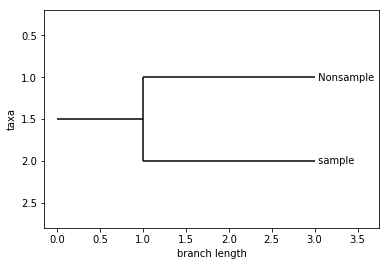

In [63]:
tree_p1 = Phylo.read(StringIO("(Nonsample:2, sample:2):1"), "newick")
Phylo.draw(tree_p1)

- #### the operation to the pattern:

> (:a.aaaaaa,sample:b.bbbbbb):c.cccccc   =>   sample:b.bbbbbb+c.cccccc

###  2.2 Pattern 2: 
- #### regex:
> \(sample:[0-9].[0-9]{3,6},:[0-9].[0-9]{3,6}\):[0-9].[0-9]{3,6}

- #### match pattern:

    > **(:sample:**a.aaaaaa,b.bbbbbb**):**c.cccccc

- #### represents tree pattern:


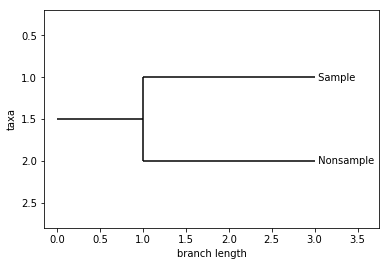

In [66]:
tree_p2 = Phylo.read(StringIO("(Sample:2, Nonsample:2):1"), "newick")
Phylo.draw(tree_p2)

- #### the operation to the pattern:

>   (:sample:a.aaaaaa,b.bbbbbb**):**c.cccccc =>   sample:a.aaaaaa+c.cccccc


### 2.3 Pattern 3: 
- #### regex:
> \(:[0-9].[0-9]{3,6},:[0-9].[0-9]{3,6}\):[0-9].[0-9]{3,6}

- #### match pattern like:

    > **(:**a.aaaaaa,:b.bbbbbb**):**c.cccccc

- #### represents tree pattern like:


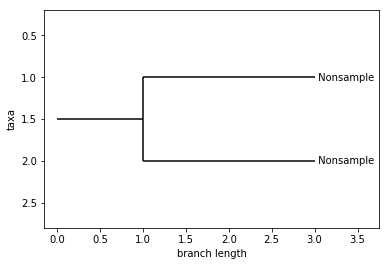

In [67]:
tree_p3 = Phylo.read(StringIO("(Nonsample:2, Nonsample:2):1"), "newick")
Phylo.draw(tree_p3)

- #### the operation to the pattern:

>   (:a.aaaaaa,:b.bbbbbb**):**c.cccccc =>  null

### 2.4 Summary of 3 patterns:

 - #### A tree integrated with 3 patterns 
 (actually 4, but the sample-sample branch can be ignore since they don't entail to operation ):

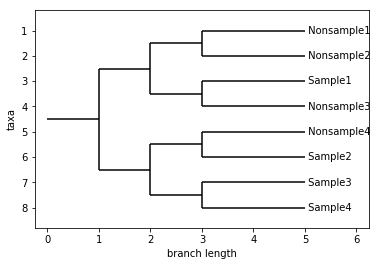

In [101]:
tree = Phylo.read(StringIO("(((Nonsample1:2, Nonsample2:2):1,(Sample1:2, Nonsample3:2):1):1,((Nonsample4:2, Sample2:2):1,(Sample3:2, Sample4:2):1):1):1"), "newick")
Phylo.draw(tree)


- #### After operation:



> **Step1**: remove Nonsample1 & Nonsample2 <br>
>((Nonsample1:2, Nonsample2:2):1,(Sample1:2, Nonsample3:2):1):1,((Nonsample4:2, sample2:2):1,(sample3:2, sample4:2):1):1

> **Step2**: remove Nonsample3 & add root age to Sample1 <br>
>((Sample1:2, Nonsample3:2):1):1,((Nonsample4:2, sample2:2):1,(sample3:2, sample4:2):1):1

> **Step3**: remove Nonsample4 & add root age to Sample2  <br>
>((Sample1:2+1):1,((Nonsample4:2, sample2:2):1,(sample3:2, sample4:2):1):1

> **Step4**: do nothing to sample3 & sample4  <br>
>((Sample1:2+1):1,((sample2:2+1,(sample3:2, sample4:2):1):1

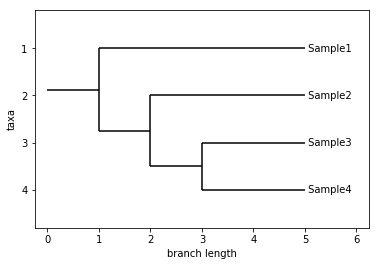

In [100]:
tree = Phylo.read(StringIO("((Sample1:3):1,(Sample2:3,(Sample3:2, Sample4:2):1):1):1"), "newick")
Phylo.draw(tree)

### 2.5 Limitation of 3 patterns:

> As you can see, this operation can solve the combination and deletion of outermost (or most right) branches. It can solve the whole problem if the tree always follows patterns in outermost (or most right) branches after each operations. However, if a Nonsample branch happens to divide into 2 samples branches(or attain this result after operations of most right branches). Our algorithm failes to go on solving this problems, another condition is, it also can not detect the useless branch happens in the very begining - if The root node of the whole tree divide into a nonsample branch, and that nonsample branch does not evolve in the following time. In summary, any condition that hinders the formation of 3 patterns will make this algorithm stop before the problem solved. As shown in the following tree, there are nothing to do using the algorithm before:

> **Condition 1: A Nonsample branch happens to divide into 2 samples branches (or attain this result after operations of most right branches)**

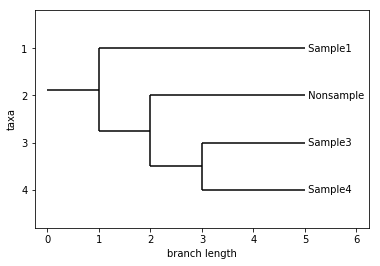

In [99]:
limit = Phylo.read(StringIO("((Sample1:3):1,(Nonsample:3,(Sample3:2, Sample4:2):1):1):1"), "newick")
Phylo.draw(limit)

> **Condition 2: The root node of the whole tree divide into a nonsample branch, and that nonsample branch does not evolve in the following time .**

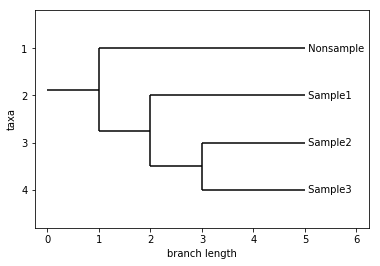

In [108]:
limit = Phylo.read(StringIO("((Nonsample:3):1,(Sample1:3,(Sample2:2, Sample3:2):1):1):1"), "newick")
Phylo.draw(limit)

## 3. A new model:

### 3.1 Now what?

> $\forall$ tree with 3 sample branches, after all operations, the final pruned version always follows this pattern:

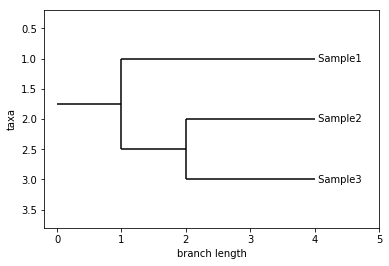

In [112]:
'''
                             b
                  ---------------------- 
          e       |
                  |
    --------------|
    |             |  a
 d  |             ------
----|
    |            (y-shape-pattern)
    |
    | c
    -----


5-------4-------3-------2-------1-------0


'''


> It is easy to prove, since there are always, at some point, two sample branches linked together (I'll call it "y-shape-pattern" ), otherwise , if root node linked directly to two sample branches, there won't have the third sample branches

> This model is very straightforward, all the numbers in final newick format string are labeled here. That means, all we need to know is this 5 numbers. And the 3-pattern model already give us a "y-shape-pattern" (naturally, because it won't stop until there is no linked two-non-sample branches linked or non-sample&sample branches linked left), that's a good news - we already locate two sample branches togther.

> The following work is, how can we locate all three sample branches (know their dead time or age). After the 3-pattern model, we got a reduced tree. We now have a "y-shape-pattern" and two poorly solved conditions stated before. And if we could remove the rest non-sample branches happens in these undesired conditions, all the numbers left are part of the final result (illustated in the following graph).

![微信截图_20190204005452.png](https://i.loli.net/2019/02/04/5c571d3121e22.png)

### 3.2 remove rest of non-sample branches

Luckily, pattern now works again, 

Since all pattern like (:a.aaaaaa,sample:b.bbbbbb):c.cccccc / (sample:a.aaaaaa,:b.bbbbbb):c.cccccc / (:a.aaaaaa,:b.bbbbbb):c.cccccc have been removed, so the rest must be in either:

### (1)....(sample:a.aaaaaa,sample:b.bbbbbb):c.cccccc.... 

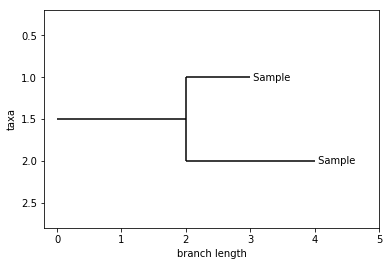

In [124]:
rr1 = Phylo.read(StringIO("((Sample:1, Sample:2):1):1"), "newick")
Phylo.draw(rr1)

### (2)....(....),sample:a.aaaaaa.... 

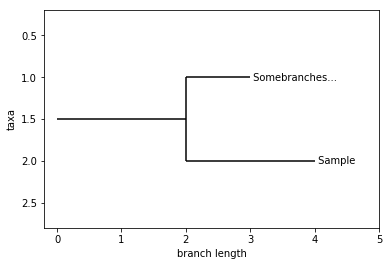

In [134]:
rr2 = Phylo.read(StringIO("((Somebranches...:1, Sample:2):1):1"), "newick")
Phylo.draw(rr2)

### (3)....(:a.aaaaaa (....) ....

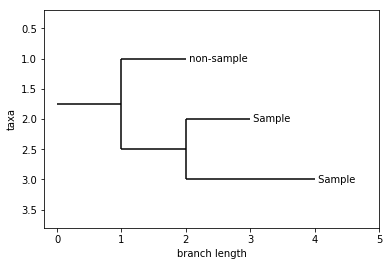

In [135]:
rr3 = Phylo.read(StringIO("(non-sample:1,(Sample:1, Sample:2):1):1"), "newick")
Phylo.draw(rr3)

### (4)...(....),a.aaaaaa

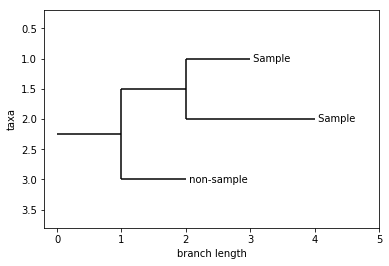

In [138]:
rr4 = Phylo.read(StringIO("((Sample:1, Sample:2):1,non-sample:1):1"), "newick")
Phylo.draw(rr4)

> Since no possiblities other than the four patterns, we can utilize this to match use regex again and remove the rest non-sample branches:

- #### (1) (:a.aaaaaa,   => ' '   
    - regex: "\\(:[0-9].[0-9]{4,6},"
- #### (2) ,:b.bbbbbb    => ' '   
    - regex: ",:[0-9].[0-9]{4,6}"

### 3.3 final work

> Congratulation! After all the non-sample branches were removed, we now can calculate the age of all three sample branche (the time they stop). Without interference of non-sample branches, we can add up all the blue lengths in the following graph:

![微信截图_20190204005452.png](https://i.loli.net/2019/02/04/5c571d3121e22.png)

In [ ]:
'''
                             b
                  ---------------------- 
          e       |
                  |
    --------------|
    |             |  a
 d  |             ------
----|
    |            (y-shape-pattern)
    |
    | c
    -----


5-------4-------3-------2-------1-------0


'''

In [ ]:
 branches_len = list(map(float, re.findall(r'[0-9].[0-9]{3,6}', newick_str))) # get all branch length remained
    branches_len.remove(a) # remove length of a, which can be get direcly from  ...sample:(x.xxxxxx), x.xxxxxx is final length of a
    branches_len.remove(c) # remove length of c, which can be get direcly from  ...sample:(x.xxxxxx)

> This ensures we will get the age of branch b, and then length of branch a can be calculate by simple arithmetics: 
- *age_of_a = age of b - branch length of b +  branch length of a*

><br> then age of c:
- *age_of_c = 1 + 3 + 5 - age_of_b - age_of_a*

> Easy to get:
- *d = the_age_of_c - c*
- *e = the_age_of_a - a - d*

### The final result can be expressed by:
>(1:c, (2: a, 3: b: e)): d;

### SOURCE CODE

In [149]:
def reduce_tree(newick_str_file):
    local_newickfile = newick_str_file
    local_newickfile = local_newickfile.replace(' ', '')
    while len(re.findall(allPattern, local_newickfile)) != 0:
        findAllPatterns = re.findall(allPattern, local_newickfile)
        for patterns in findAllPatterns:
            Pattern_3 = r"\(:[0-9].[0-9]{3,6},:[0-9].[0-9]{3,6}\)(?=:[0-9].[0-9]{3,6})"

            if re.match(Pattern_3, patterns) is not None:
                local_newickfile = re.sub(Pattern_3, '', local_newickfile)

            else:
                OldLiveTime = re.findall(r"(?<=sample:)[0-9].[0-9]{3,6}|(?<=\):)[0-9].[0-9]{3,6}", patterns)
                newLiveTime = sum(map(float, OldLiveTime))
                local_newickfile = local_newickfile.replace(patterns, "sample:" + str(round(newLiveTime, 6)))
    #updated_file = open("preprocessed_sequence.tree", "w")
    #updated_file.write(local_newickfile)
    local_newickfile = re.sub("\(:[0-9].[0-9]{4,6},|,:[0-9].[0-9]{4,6}",'',local_newickfile)#cut_initial_freebrach
    return local_newickfile




def parse_newick(newick_str):
    newick_str = reduce_tree(newick_str)
    y_shape_pattern = r"\(sample:[0-9].[0-9]{3,6},sample:[0-9].[0-9]{3,6}\)"  #the linked two branch pattern
    a_b = list(map(float, re.findall("[0-9].[0-9]{3,6}", re.findall(y_shape_pattern, newick_str)[0])))
    a = min(a_b)
    b = max(a_b)
    a_b_c = list(map(float, re.findall(r'(?<=sample:)[0-9].[0-9]{3,6}',newick_str)))
    a_b_c.remove(a)
    a_b_c.remove(b)
    c = a_b_c[0]

    branches_len = list(map(float, re.findall(r'[0-9].[0-9]{3,6}', newick_str)))
    branches_len.remove(c)
    branches_len.remove(a)

    b_tAge = round(sum(branches_len))
    a_tAge = round(b_tAge-b+a)
    c_tAge = round(9-a_tAge-b_tAge)
    
    d = c_tAge-c
    e = a_tAge - a - d
    
    #print(a,b,c,d,e,'\n',a_tAge,b_tAge,c_tAge)
    
    if round(b_tAge - b - d) == round(e):
        return str(r"(1:%(c)f,(2:%(a)f,3:%(b)f):%(e)f):%(d)f;" %{
                                                                'a':a,
                                                                'b':b,
                                                                'c':c,
                                                                'd':d,
                                                                'e':e,})
        pass
    else:
        print("none considered condition")

### DEMO #1

In [146]:
test1 = '( ( (:0.219981, sample:0.153762):1.262133,  ( ( ( ( (:0.691503,  (:0.471135, :0.471135):0.220369):0.816752,  (:0.228056, :0.228056):1.280199):0.408618,  (:0.213074, :0.213074):1.703799):0.052233,  ( (:0.270947, :0.270947):0.715234,  ( (:0.012964, :0.012964):0.102794, :0.115757):0.870424):0.982924):0.029266,  ( ( ( ( (:0.188922, :0.188922):0.117463, sample:0.306385):0.405095, :0.711480):0.337688,  (:0.340493, :0.340493):0.708675):0.858316,  ( (:0.686347, :0.686347):0.134548,  (:0.498012,  (:0.130056, :0.130056):0.367956):0.322884):1.086588):0.090888):1.417523):0.614676, sample:0.030571):0.969429;'
input_test1_tree = Phylo.read(StringIO(test1), "newick")
test1

'( ( (:0.219981, sample:0.153762):1.262133,  ( ( ( ( (:0.691503,  (:0.471135, :0.471135):0.220369):0.816752,  (:0.228056, :0.228056):1.280199):0.408618,  (:0.213074, :0.213074):1.703799):0.052233,  ( (:0.270947, :0.270947):0.715234,  ( (:0.012964, :0.012964):0.102794, :0.115757):0.870424):0.982924):0.029266,  ( ( ( ( (:0.188922, :0.188922):0.117463, sample:0.306385):0.405095, :0.711480):0.337688,  (:0.340493, :0.340493):0.708675):0.858316,  ( (:0.686347, :0.686347):0.134548,  (:0.498012,  (:0.130056, :0.130056):0.367956):0.322884):1.086588):0.090888):1.417523):0.614676, sample:0.030571):0.969429;'

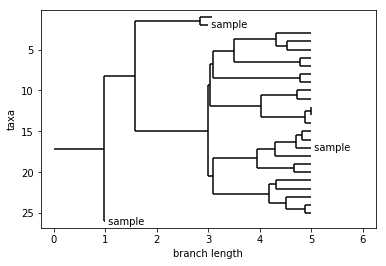

In [147]:
Phylo.draw(input_test1_tree)

In [152]:
reduced_test1 = reduce_tree(test1)
reduced_test1_tree = Phylo.read(StringIO(reduced_test1), "newick")
reduced_test1

'((sample:1.415895,sample:3.415895):0.614676,sample:0.030571):0.969429;'

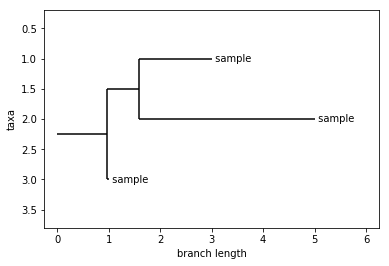

In [153]:
Phylo.draw(reduced_test1_tree)

In [171]:
output_test1 = parse_newick(test1)
output_test1_tree = Phylo.read(StringIO(output_test1), "newick")
output_test1

'(1:0.030571,(2:1.415895,3:3.415895):0.614676):0.969429;'

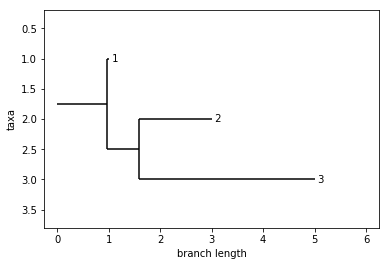

In [172]:
Phylo.draw(output_test1_tree)

### DEMO #2

In [175]:
test2 = "( ( ( ( ( ( (:0.097894, sample:0.097894):1.149562,  ( ( (:0.212954, :0.212954):0.079402, :0.292356):0.452899,  (:0.488000, :0.488000):0.257255):0.502201):1.024322, sample:0.271778):0.052542,  (:0.243957, :0.589506):0.420304):1.189132,  ( (:0.573204,  ( (:0.020658, :0.020658):0.113083,  (:0.040249, :0.040249):0.093491):1.081006):0.743244,  (:0.422722, :0.422722):1.535269):1.555461):0.685700, sample:0.199152):0.765934, :0.242619):0.034914;"
input_test2_tree = Phylo.read(StringIO(test2), "newick")
test2

'( ( ( ( ( ( (:0.097894, sample:0.097894):1.149562,  ( ( (:0.212954, :0.212954):0.079402, :0.292356):0.452899,  (:0.488000, :0.488000):0.257255):0.502201):1.024322, sample:0.271778):0.052542,  (:0.243957, :0.589506):0.420304):1.189132,  ( (:0.573204,  ( (:0.020658, :0.020658):0.113083,  (:0.040249, :0.040249):0.093491):1.081006):0.743244,  (:0.422722, :0.422722):1.535269):1.555461):0.685700, sample:0.199152):0.765934, :0.242619):0.034914;'

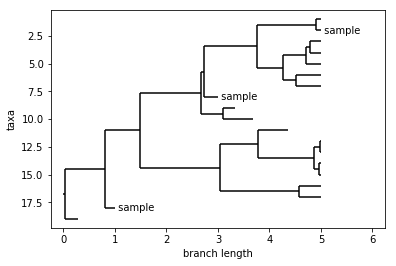

In [177]:
Phylo.draw(input_test2_tree)

In [180]:
reduced_test2 = reduce_tree(test2)
reduced_test2_tree = Phylo.read(StringIO(reduced_test2), "newick")
reduced_test2

'(((((sample:2.271778,sample:0.271778):0.052542):1.189132):0.685700,sample:0.199152):0.765934):0.034914;'

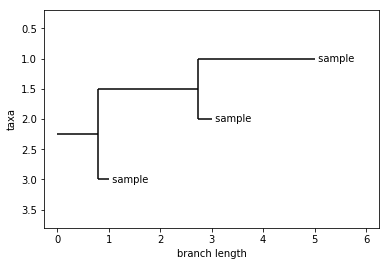

In [181]:
Phylo.draw(reduced_test2_tree)

In [182]:
output_test2 = parse_newick(test2)
output_test2_tree = Phylo.read(StringIO(output_test2), "newick")
output_test2

'(1:0.199152,(2:0.271778,3:2.271778):1.927374):0.800848;'

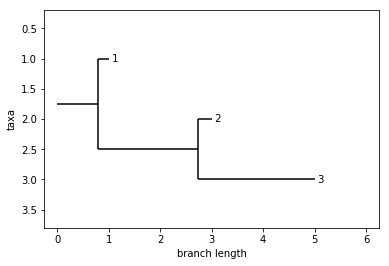

In [183]:
Phylo.draw(output_test2_tree)